

# **Prediccion del default**

El objetivo del caso de estudio es construir un modelo de machine learning que prediga la probabilidad de que un prestamo caiga en default.

# **Contenido**
1. Definir del problema
2. Cargar data y herramientas
3. Preparar data
4. Feature engineering y EDA
5. Evaluar modelos
6. Ajustar modelos
7. Testing

# **1. Definir del problema**

El problema se define en el marco de clasificación, donde la variable a predecir (*target* o *outcome*) es la cualidad de "mal pagador" de un cliente de credito.
La variable predicha toma el valor 1 si el cliente es "malo" y 0 en caso contrario.

Este estudio de caso tiene como objetivo analizar la data de prestamos de un Banco Aleman ([German Credit Data](https://archive-beta.ics.uci.edu/ml/datasets/144)). La data original contiene 1000 observaciones (clientes) y 20 variables con nombres y valores codificados. Para esta aplicacion se utilizara una version etiquetada de la data. 

# **2. Cargar data y herramientas**

## Paquetes de Python

In [1]:
# funciones matematicas
import numpy as np

# trabajo con tablas
import pandas as pd
from pandas import read_csv, set_option
from pandas.plotting import scatter_matrix

# graficos
import matplotlib as mpl
from matplotlib import pyplot
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
import seaborn as sns

# modelamiento: preprocesamientodataset['log_amount'] = np.log10(dataset['Credit amount'] + 1)
from sklearn.preprocessing import StandardScaler

# modelamiento: train-test split
from sklearn.model_selection import train_test_split

# modelamiento: cross-validation
from sklearn.model_selection import KFold, StratifiedKFold, RepeatedStratifiedKFold, cross_val_score, GridSearchCV

# modelamiento: algoritmos basicos
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

# modelamiento: algoritmos ensemble 
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier

# reporte de resultados
import shap
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
from sklearn.pipeline import Pipeline

# guardar modelos
from pickle import dump
from pickle import load

## **Cargar la data**
Para este estudio de caso se utilizara la version etiquetada de German Credit Data. Para descargar la data ingresar al siguiente [enlace](https://bit.ly/3hegYcG).

In [2]:
# cargar la data
german = pd.read_csv("inputs/german_credit_data.csv", index_col=0)

In [3]:
german.head(10)

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,49,male,1,own,little,NaN,2096,12,education,good
3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,53,male,2,free,little,little,4870,24,car,bad
5,35,male,1,free,NaN,NaN,9055,36,education,good
6,53,male,2,own,quite rich,NaN,2835,24,furniture/equipment,good
7,35,male,3,rent,little,moderate,6948,36,car,good
8,61,male,1,own,rich,NaN,3059,12,radio/TV,good
9,28,male,3,own,little,moderate,5234,30,car,bad


In [4]:
# tomar una copia de la data original
dataset = german.copy()

In [5]:
# cual es el tipo de la data
type(dataset)

pandas.core.frame.DataFrame

In [6]:
# un view general de la data
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Age               1000 non-null   int64 
 1   Sex               1000 non-null   object
 2   Job               1000 non-null   int64 
 3   Housing           1000 non-null   object
 4   Saving accounts   817 non-null    object
 5   Checking account  606 non-null    object
 6   Credit amount     1000 non-null   int64 
 7   Duration          1000 non-null   int64 
 8   Purpose           1000 non-null   object
 9   Risk              1000 non-null   object
dtypes: int64(4), object(6)
memory usage: 85.9+ KB


# 3. Explorar y preparar data

## **Preparar el target (variable a predecir)**
Los algoritmos aprenderan las diferencias en features entre malos y buenos pagadores. La variable original que contine info de est *target* es `Risk`.

Primero haremos una inspeccion de la variable `Risk`.

In [7]:
dataset['Risk'].value_counts(dropna=False)
dataset['Risk'].value_counts(normalize=True, dropna=False)

good    0.7
bad     0.3
Name: Risk, dtype: float64

Cerca del 70% tiene una buena calificacion (buen pagador) 30% tiene una mala calificacion crediticia. Asi, estamos frente a un problema de clasificacion desbalanceado.

In [8]:
dataset['bad'] = (dataset['Risk'] == 'bad')
# dataset = dataset.drop('Risk', axis=1)

In [9]:
dataset['bad']

0      False
1       True
2      False
3      False
4       True
       ...  
995    False
996    False
997    False
998     True
999    False
Name: bad, Length: 1000, dtype: bool

## Seleccion de features
Algunos criterios para eliminar features:
* Tienen demasiado missing (umbral a juicio del negocio o analista).
* Tienen casi cero varianza.
* No tienen una relacion intuitiva con el target/outcome (juicio subjetivo).

### **Eliminacion por missings**
Primero exploremos la incidencia de missings en la data.

In [10]:
prop_missing = dataset.isnull().mean().sort_values(ascending=False)
prop_missing

Checking account    0.394
Saving accounts     0.183
Age                 0.000
Sex                 0.000
Job                 0.000
Housing             0.000
Credit amount       0.000
Duration            0.000
Purpose             0.000
Risk                0.000
bad                 0.000
dtype: float64

Ahora capturemos los nombres de las columnas que sobrepasan un porcentaje de missings de 30% para eliminarlos posteriormente.

In [11]:
drop_list = sorted(list(prop_missing[prop_missing > 0.3].index))
print(drop_list)

['Checking account']


Utilizaremos la lista creada para eliminar estos campos (columnas) de la data. Para eliminar columnas usamos el metodo `.drop()` aplicable a objetos `DataFrames` de Pandas.

In [12]:
dataset = dataset.drop(labels=drop_list, axis=1)

# verificamos la nueva forma de la tabla
dataset.shape

(1000, 10)

### **Eliminacion por baja correlacion**

Utilizamos el metodo `.corr()` aplicable a `DataFrames` de Pandas. Esto genera otro `DataFrame` con la matriz de correlacion de las variables numericas.

In [13]:
matriz_correlacion = dataset.corr()
print(type(matriz_correlacion))
matriz_correlacion

<class 'pandas.core.frame.DataFrame'>


,Age,Job,Credit amount,Duration,bad
Age,1.000000,0.015673,0.032716,-0.036136,-0.091127
Job,0.015673,1.000000,0.285385,0.210910,0.032735
Credit amount,0.032716,0.285385,1.000000,0.624984,0.154739
Duration,-0.036136,0.210910,0.624984,1.000000,0.214927
bad,-0.091127,0.032735,0.154739,0.214927,1.000000


Nos interesa la correlacion con el target, asi que seleccionamos solo esa columna de la matriz de correlacion:

In [14]:
correlacion_bad = abs(matriz_correlacion['bad'])
correlacion_bad.sort_values(ascending=False)

bad              1.000000
Duration         0.214927
Credit amount    0.154739
Age              0.091127
Job              0.032735
Name: bad, dtype: float64

Aparentemente, el empleo y la edad tienen una correlacion particularmente baja con el target. Pero, valdra la pena eliminarlos?

In [15]:
# bajacorr_drop_list = ["Age", "Job"] 
# dataset = dataset.drop(labels=bajacorr_drop_list, axis=1)

# 4. Feature Engineering y Exploratory Data Analysis (EDA)

## **Analisis de features numericos**

In [16]:
# estadisticas descriptivas
dataset.describe()

,Age,Job,Credit amount,Duration
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,35.546000,1.904000,3271.258000,20.903000
std,11.375469,0.653614,2822.736876,12.058814
min,19.000000,0.000000,250.000000,4.000000
25%,27.000000,2.000000,1365.500000,12.000000
50%,33.000000,2.000000,2319.500000,18.000000
75%,42.000000,2.000000,3972.250000,24.000000
max,75.000000,3.000000,18424.000000,72.000000


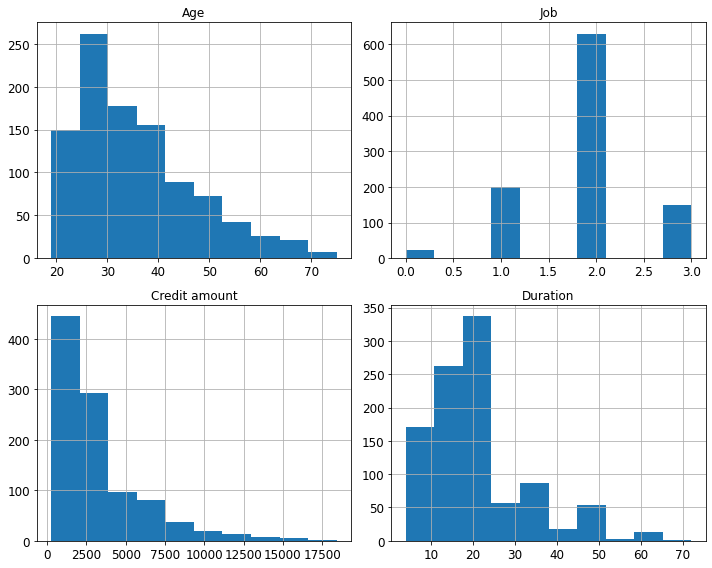

In [17]:
dataset.hist(bins=10, figsize=(10, 8))
plt.tight_layout()

#### Logaritmo de variable continua con cola (credit amount)

In [18]:
# usando lambda functions (cuando la funcion no tiene aplicacion vectorial por default)
# dataset['log_amount'] = dataset['Credit amount'].apply(lambda x: np.log10(x+1))

In [19]:
# mas facil de leer (pero no siempre va a aplicar para cualquier funcion)
dataset['log_amount'] = np.log10(dataset['Credit amount'] + 1)

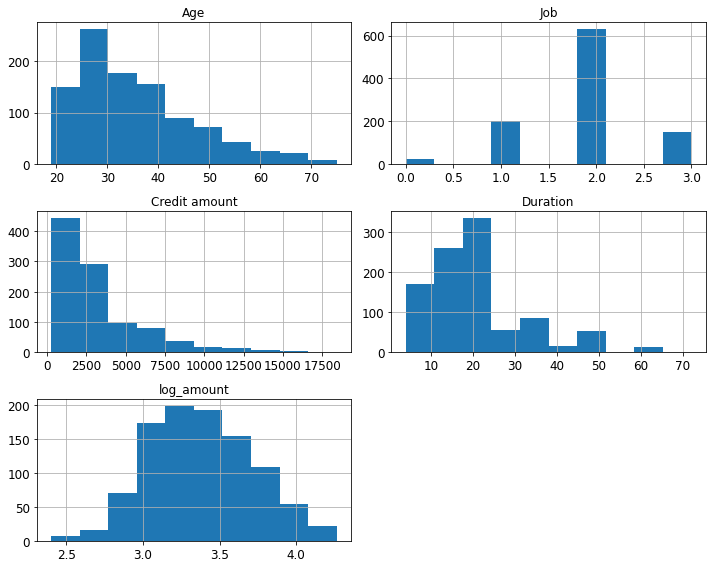

In [20]:
dataset.hist(bins=10, figsize=(10, 8))
plt.tight_layout()

In [21]:
dataset = dataset.drop("Credit amount", axis=1)

### Analisis bivariado con variables numericas

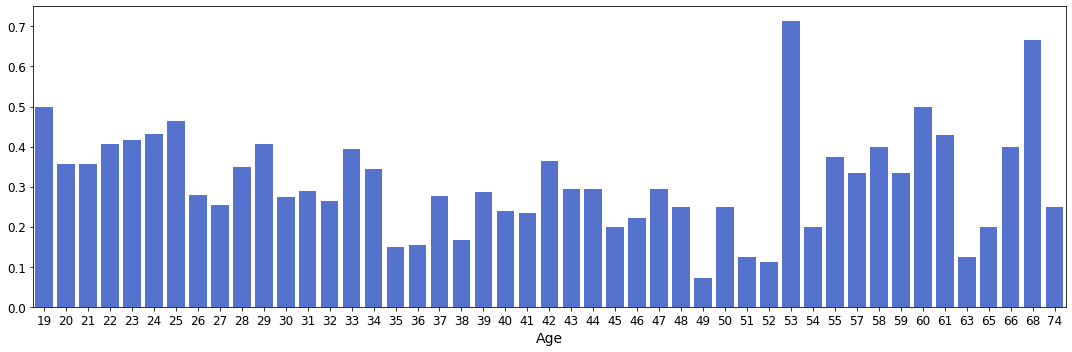

In [22]:
tasas_bad = dataset.groupby('Age')['bad'].value_counts(normalize=True).loc[:,1]
fig, ax = pyplot.subplots(figsize=(15, 5))
sns.barplot(x=tasas_bad.index, y=tasas_bad.values, color='royalblue')
plt.tight_layout()

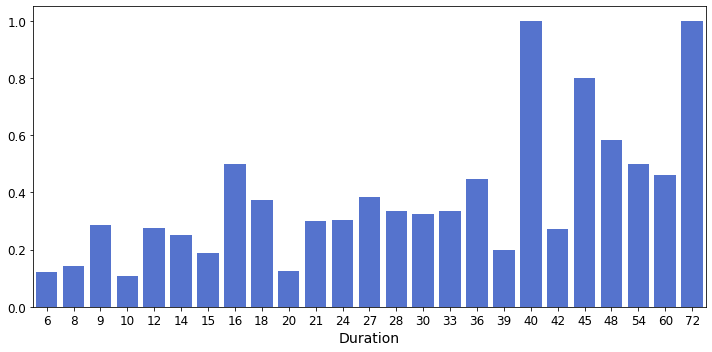

In [23]:
tasas_bad = dataset.groupby('Duration')['bad'].value_counts(normalize=True).loc[:,1]
fig, ax = pyplot.subplots(figsize=(10, 5))
sns.barplot(x=tasas_bad.index, y=tasas_bad.values, color='royalblue')
plt.tight_layout()

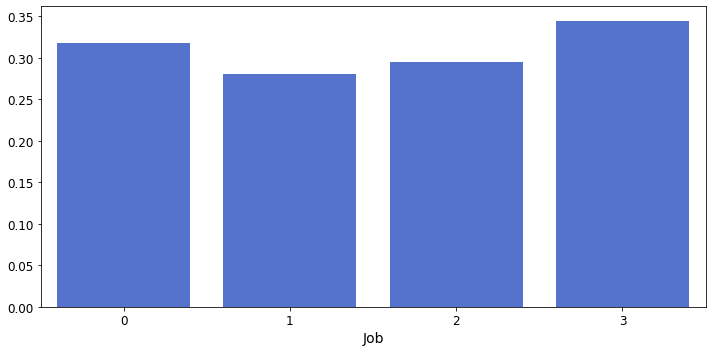

In [24]:
tasas_bad = dataset.groupby('Job')['bad'].value_counts(normalize=True).loc[:,1]
fig, ax = pyplot.subplots(figsize=(10, 5))
sns.barplot(x=tasas_bad.index, y=tasas_bad.values, color='royalblue')
plt.tight_layout()

Un vistazo mas general de la relacion entre el target y variables numericas:

In [25]:
def targetByNumericsPlot(data, target):
    """Genera multiples boxplots de las variables numericas, segun las categorias del target."""
    numericVars = (data.select_dtypes(include="number").columns.sort_values())
    numCols = 4 if len(numericVars)>4 else 2
    fig, ax = plt.subplots((len(numericVars) + (numCols-1)) // numCols, numCols, figsize=(15, 10))
    for variable, subplot in zip(numericVars, ax.flatten()):
        sns.boxplot(data=data, y=target, x=variable, ax=subplot)
        subplot.set(title=variable, xlabel="", ylabel="")
        subplot.grid(b=True, axis="both")
    ## Axis que deben quedar vacios
    if len(numericVars)%numCols!=0:
        for emptyAxColIndex in list(range(1, numCols-(len(numericVars)%numCols)+1)):
            ax[-1, -emptyAxColIndex].axis('off')
    plt.tight_layout()

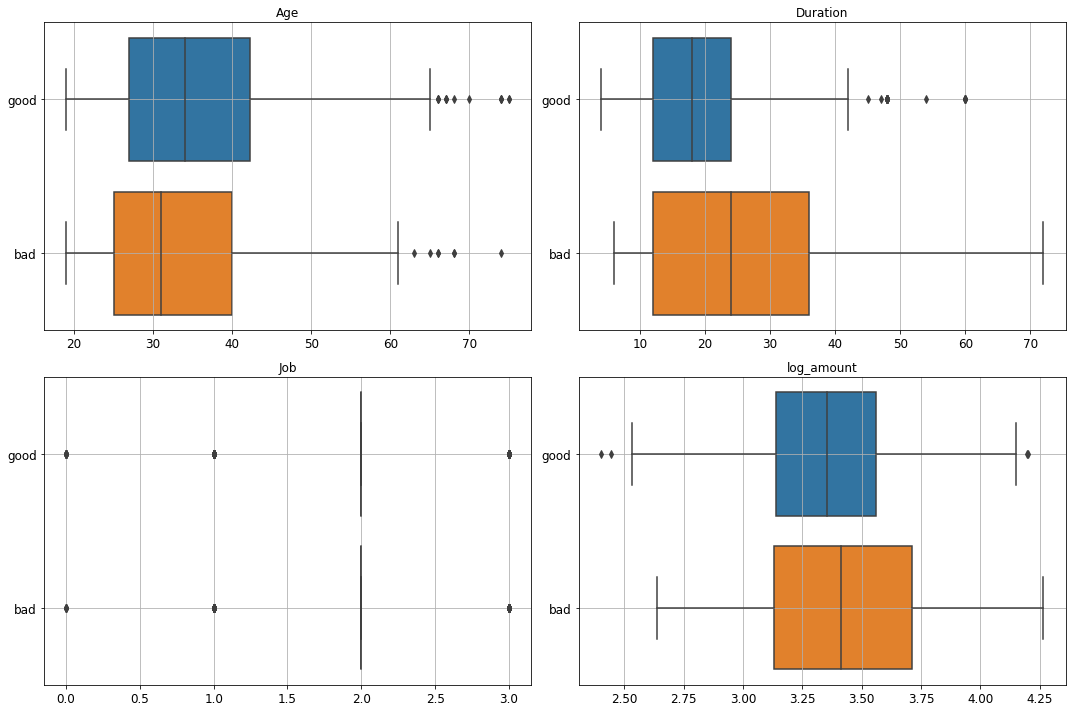

In [26]:
targetByNumericsPlot(dataset, "Risk")

## Analisis de features categoricos

In [27]:
dataset[['Housing','Saving accounts', 'Purpose']].describe()

,Housing,Saving accounts,Purpose
count,1000,817,1000
unique,3,4,8
top,own,little,car
freq,713,603,337


In [28]:
def findLess20CategVars(data):
    """Genera una lista con las variables categoricas que tienen menos de 20 categorias."""
    categVars = list()
    for column in data:
        if (data.dtypes[column] == object) & (data[column].unique().shape[0] < 20):
            categVars.append(column)
    return categVars

def targetByCategPlot(data, target, numCols=2, dropna=False):
    """Grafica el promedio del target para cada categoria de las variables categoricas. El target debe ser un valor numerico."""
    categVars = sorted(findLess20CategVars(data.drop(target, axis=1)))
    fig, ax = plt.subplots((len(categVars)+(numCols-1))//numCols, numCols, figsize=(15, 20))
    for variable, subplot in zip(categVars, ax.flatten()):
        myTable = (
            data[target]
            .groupby(data[variable])
            .agg("mean")
            .reset_index()
        )
        myTable[target] = myTable[target]*10 
        sns.barplot(data=myTable, x=target, y=variable, orient="h", ax=subplot) 
        subplot.set(title=variable, xlabel="", ylabel="")
        subplot.grid(b=True, axis="x")
    ## Axis que deben quedar vacios
    if len(categVars)%numCols!=0:
        for emptyAxColNumber in list(range(1, len(categVars)%numCols+1)):
            ax[-1, -emptyAxColNumber].axis('off')
    plt.tight_layout()

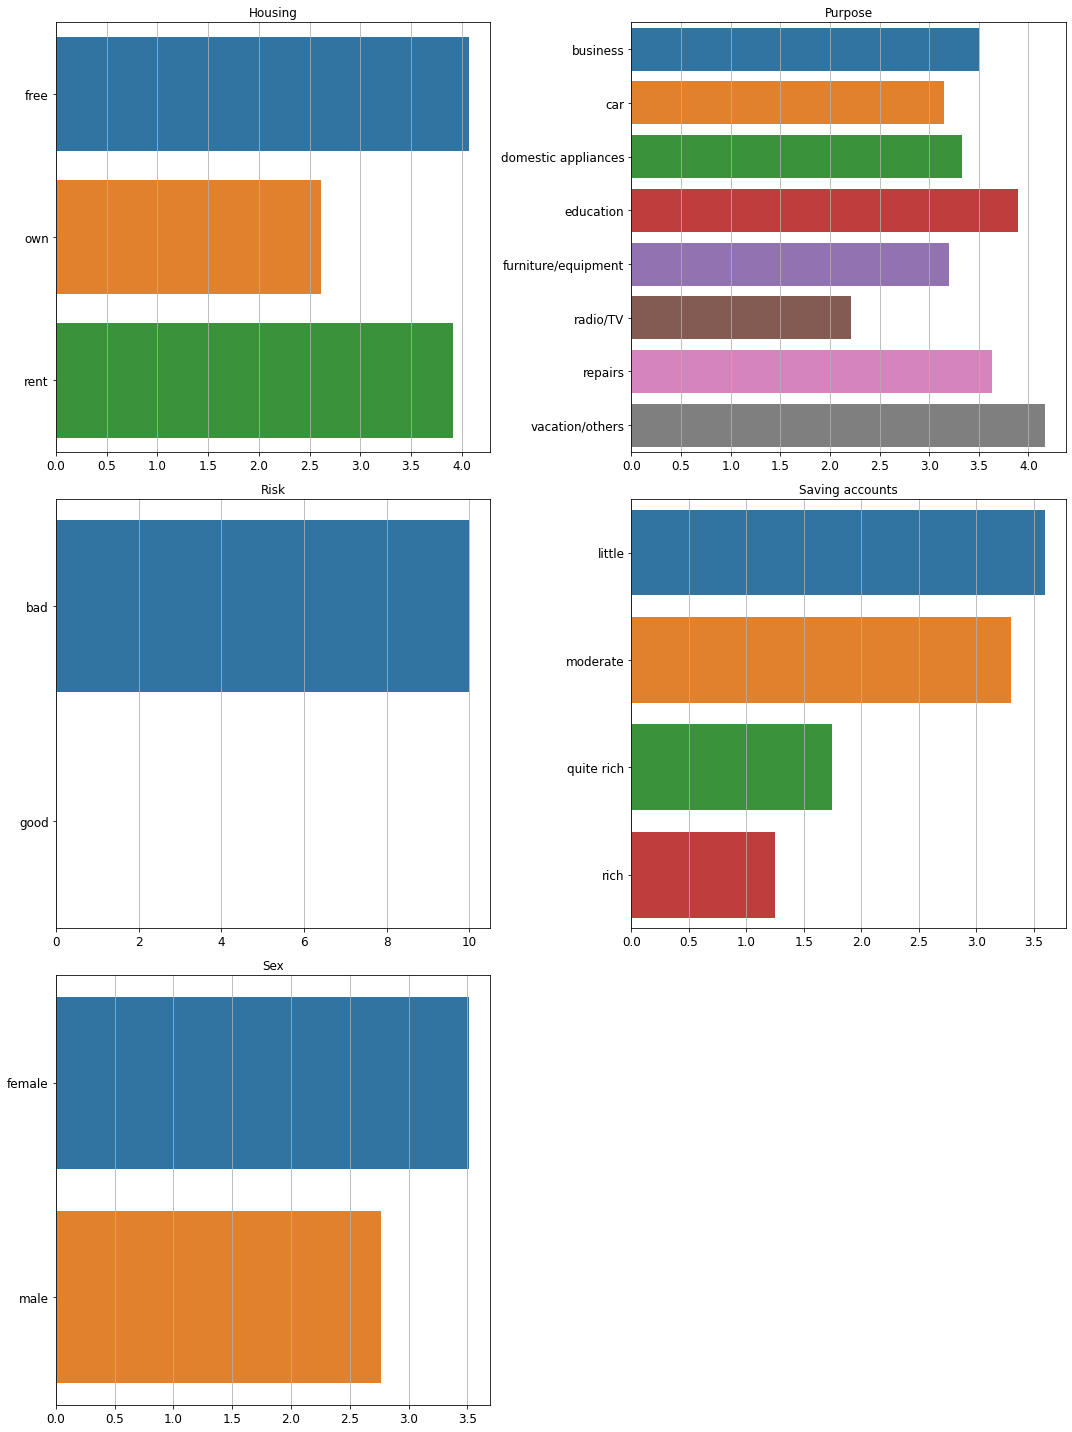

In [29]:
targetByCategPlot(dataset, "bad")
plt.tight_layout()

La mayoria de algoritmos trabajan mejor con data numerica que con data en forma de texto, asi que es necesario transformar la data de texto. Este proceso de transformacion se conoce como ***encoding***. Hay multiples tecnicas de **encoding** y su uso depende del significado de la variable a transformar y sus categorias.

### Ordinal encoding

Por ejemplo, la variable `Saving accounts` toma los siguientes valores:


In [30]:
dataset['Saving accounts'].unique()

array([nan, 'little', 'quite rich', 'rich', 'moderate'], dtype=object)

Claramente hay un orden implicito en estas categorias. Por ejemplo, la categoria "*rich*" indica una cuenta de ahorros mayor que "*quite rich*" o "*moderate*". Asi, la codificacion de esta varaible debe reflejar la existencia de un orden. En este tipo de casos se usa la tecnica de ***ordinal encoding***.

In [31]:
conds = [
    dataset['Saving accounts'].isna(), 
    dataset['Saving accounts']=="little", 
    dataset['Saving accounts']=="moderate", 
    dataset['Saving accounts']=="quite rich", 
    dataset['Saving accounts']=="rich"
]
choices = [np.nan, 1, 2, 3, 4]
dataset['saving_accounts_encoded'] = np.select(conds, choices)


Verifiquemos la codificacion. Tomamos 10 observaciones al azar con el metodo `.sample()`. Un argumento de todo metodo que implica aleatoriedad es `random_state` que garantiza la reproducibilidad de los resultados. Finalmente usamos el metodo `.loc[]` para hacer un slicing de la tabla y elegir los campos que queremos comparar.

**Nota:** `random_state` puede tomar cualquier numero arbitrario. Elegimos 42 por la [siguiente razon](https://news.mit.edu/2019/answer-life-universe-and-everything-sum-three-cubes-mathematics-0910).

In [32]:
dataset.sample(n=10, random_state=42).loc[:, ['Saving accounts', 'saving_accounts_encoded']]

,Saving accounts,saving_accounts_encoded
521,little,1.0
737,moderate,2.0
740,moderate,2.0
660,little,1.0
411,little,1.0
678,little,1.0
626,little,1.0
513,little,1.0
859,moderate,2.0
136,rich,4.0


In [33]:
dataset = dataset.drop(axis=1, labels='Saving accounts')
dataset = dataset.dropna(subset=['saving_accounts_encoded'])

### One-hot encoding

Otro tipo de codificacion aplica a variables cualitativas donde el orden no es significativo. En estos casos se usa el ***one hot encoding***, que genera variables *flag* (1 y 0) para cada categoria de las variables cualitativas. Para aplicar esta tecnica se puede usar la metodo `get_dummies()` de Pandas aplicable a `DataFrames`.

In [34]:
cols_para_onehot = ['Housing', 'Purpose', 'Sex']
dataset = pd.get_dummies(data=dataset, columns=cols_para_onehot, dummy_na=True, drop_first=True)

In [35]:
dataset.head().T

,1,2,3,4,6
Age,22,49,45,53,53
Job,2,1,2,2,2
Duration,48,12,42,24,24
Risk,bad,good,good,bad,good
bad,True,False,False,True,False
log_amount,3.774663,3.321598,3.896692,3.687618,3.452706
saving_accounts_encoded,1.0,1.0,1.0,1.0,3.0
Housing_own,1,1,0,0,1
Housing_rent,0,0,0,0,0
Housing_nan,0,0,0,0,0


# 5. Evaluar modelos

## Train-Test Split

In [36]:
# Definir 'X' y 'y' 
target_vars = ["Risk", "bad"]
Y= dataset["bad"]
X = dataset.loc[:, ~dataset.columns.isin(target_vars)]


In [37]:
X.head().T

,1,2,3,4,6
Age,22.000000,49.000000,45.000000,53.000000,53.000000
Job,2.000000,1.000000,2.000000,2.000000,2.000000
Duration,48.000000,12.000000,42.000000,24.000000,24.000000
log_amount,3.774663,3.321598,3.896692,3.687618,3.452706
saving_accounts_encoded,1.000000,1.000000,1.000000,1.000000,3.000000
Housing_own,1.000000,1.000000,0.000000,0.000000,1.000000
Housing_rent,0.000000,0.000000,0.000000,0.000000,0.000000
Housing_nan,0.000000,0.000000,0.000000,0.000000,0.000000
Purpose_car,0.000000,0.000000,0.000000,1.000000,0.000000
Purpose_domestic appliances,0.000000,0.000000,0.000000,0.000000,0.000000


In [38]:
# split de la data en train y test
validation_size = 0.2
seed = 42
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=validation_size, random_state=seed)

## Definir metricsa de evaluation Metrics


In [39]:
# opciones de testing para la clasificacion
num_folds = 10
seed = 42
#scoring = 'accuracy'
#scoring ='precision'
# scoring = 'recall'
scoring = 'roc_auc'

## Comparar modelos y algoritmos
Ensayaremos varios algoritmos. Siempre el enfoque en ML es: probar rapido, fallar rapido.

In [40]:
# spot check the algorithms
models = []
models.append(('LR', LogisticRegression(max_iter=1000)))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier(random_state=seed)))
#Ensable Models 
# Boosting methods
models.append(('AB', AdaBoostClassifier(random_state=seed)))
models.append(('GBM', GradientBoostingClassifier(random_state=seed)))
# Bagging methods
models.append(('RF', RandomForestClassifier(random_state=seed)))

### K-folds cross validation

In [41]:
results = []
names = []
for name, model in models:
    kfold = StratifiedKFold(n_splits=num_folds, random_state=seed, shuffle=True)
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.681608 (0.047970)
KNN: 0.577257 (0.041734)
CART: 0.588566 (0.046696)
AB: 0.694615 (0.059247)
GBM: 0.725009 (0.039761)
RF: 0.672105 (0.050978)


### Comparacion de algoritmos

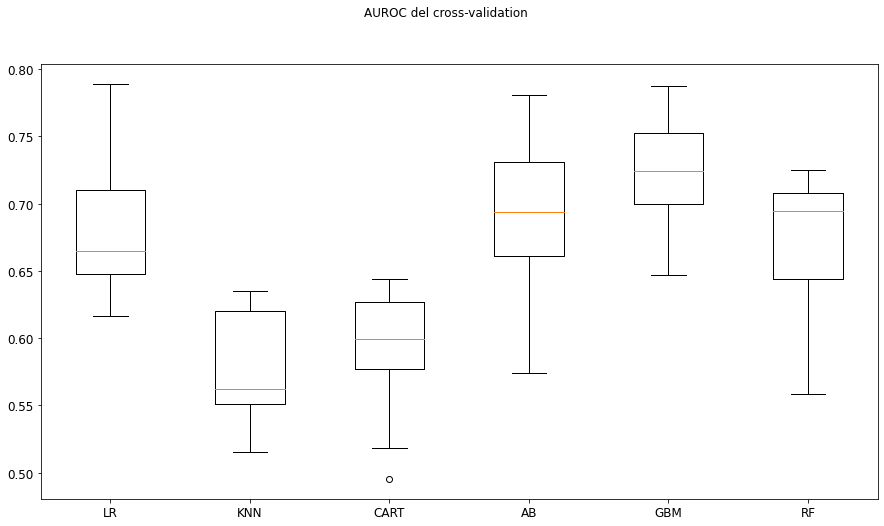

In [42]:
fig = pyplot.figure()
fig.suptitle('AUROC del cross-validation')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
fig.set_size_inches(15,8)
pyplot.show()

# 6. Ajustar y mejorar modelo
Optamos por el *RandomForest* por tener tener el menor sesgo y varianza comparable a los otros algoritmos.

In [43]:
# Grid Search: GBM
'''
n_estimators : int (default=100)
    Numero de iteraciones que realizara el algoritmo de mejora del modelo. 
''' 
model = GradientBoostingClassifier(random_state=seed)

n_estimators = [10, 50, 100, 200]

param_grid = dict(n_estimators=n_estimators)
kfold = StratifiedKFold(n_splits=num_folds, random_state=seed, shuffle=True)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(X_train, Y_train)

# Mostrar resultados
print("Mejor: %f usando %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
ranks = grid_result.cv_results_['rank_test_score']
for mean, stdev, param, rank in zip(means, stds, params, ranks):
    print("#%d %f (%f) con: %r" % (rank, mean, stdev, param))

Mejor: 0.725009 usando {'n_estimators': 100}
#4 0.686463 (0.053842) con: {'n_estimators': 10}
#2 0.720985 (0.047697) con: {'n_estimators': 50}
#1 0.725009 (0.039761) con: {'n_estimators': 100}
#3 0.711472 (0.051831) con: {'n_estimators': 200}


In [44]:
# entrenar algoritmo seleccionado con el hiperparametro optimizado
modelo_final = GradientBoostingClassifier(n_estimators=100, random_state=42)
modelo_final.fit(X_train, Y_train)

GradientBoostingClassifier(random_state=42)

El analisis de importancia de features es una herramienta de investigacion para el desarrollo de teorias.


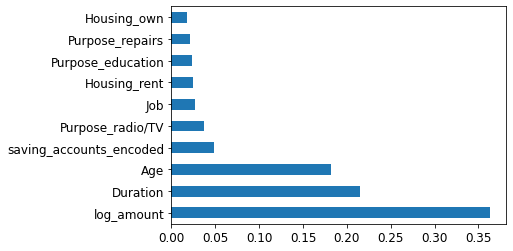

In [45]:
feat_importances = pd.Series(modelo_final.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
pyplot.show()

Una alternativa para ganar entendimiento el sentido de las dependencias en los modelos es usar [shap values](https://shap.readthedocs.io/en/latest/index.html).

In [46]:
explainer = shap.TreeExplainer(model=modelo_final, feature_perturbation="tree_path_dependent")
shap_vals = explainer.shap_values(X=X_train)

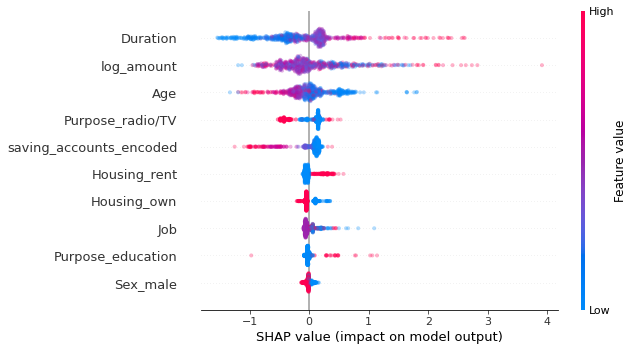

In [47]:
fig, ax = plt.subplots(figsize=(5, 15))
shap.summary_plot(shap_values=shap_vals, features=X_train, max_display=10, plot_type="dot", alpha=0.3)

**Conclusion:** Los resultados del analisis de importancia de variables y dependencia resultan intuitivos. El modelo pasara a etapa de testing.

# 7. Testing

Un primer indicador era el *accuracy* (los aciertos totales en testing).

In [48]:
# estimar la precision en la data de testing
predicciones = modelo_final.predict(X_test)
print(accuracy_score(Y_test, predicciones))


0.774390243902439


Un indicador del performance general del modelo es el area bajo la curva ROC. Mientras mas cercano a 1, mejor.

In [49]:
print(roc_auc_score(Y_test, predicciones))

0.6827605019094382


Otra forma visual de ver el performance es mediante la ***Matriz de Confusion***:

In [50]:
print(confusion_matrix(Y_test, predicciones))

[[105  12]
 [ 25  22]]


<AxesSubplot:xlabel='Predicho', ylabel='Real'>

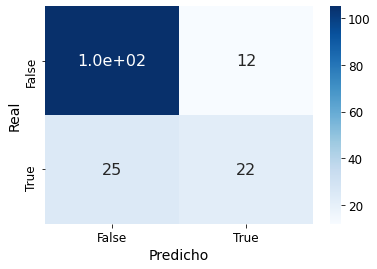

In [51]:
df_cm = pd.DataFrame(confusion_matrix(Y_test, predicciones), columns=np.unique(Y_test), index = np.unique(Y_test))
df_cm.index.name = 'Real'
df_cm.columns.name = 'Predicho'
sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})

Finalmente podemos tomar un vistazo general de distintas metricas de performance. 

In [52]:
print(classification_report(Y_test, predicciones))

              precision    recall  f1-score   support

       False       0.81      0.90      0.85       117
        True       0.65      0.47      0.54        47

    accuracy                           0.77       164
   macro avg       0.73      0.68      0.70       164
weighted avg       0.76      0.77      0.76       164

